<a href="https://colab.research.google.com/github/prosvirinKir/Deep-Learning-Sckool-term1/blob/main/simpsons_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



## **Физтех-Школа Прикладной математики и информатики (ФПМИ) МФТИ**

# Путешествие по Спрингфилду.


Сегодня вам предстоить помочь телекомпании FOX  в обработке их контента. Как вы знаете сериал Симсоны идет на телеэкранах более 25 лет и за это время скопилось очень много видео материала. Персоонажи менялись вместе с изменяющимися графическими технологиями   и Гомер 2018 не очень похож на Гомера 1989. Нашей задачей будет научиться классифицировать персонажей проживающих в Спрингфилде. Думаю, что нет смысла представлять каждого из них в отдельности.



 ![alt text](https://vignette.wikia.nocookie.net/simpsons/images/5/5a/Spider_fat_piglet.png/revision/latest/scale-to-width-down/640?cb=20111118140828)



### Установка зависимостей

In [1]:
!pip install -U torch torchvision

Requirement already up-to-date: torch in /usr/local/lib/python3.7/dist-packages (1.8.1+cu101)
Requirement already up-to-date: torchvision in /usr/local/lib/python3.7/dist-packages (0.9.1+cu101)


In [2]:
# установка подходящей версии torch

from os.path import exists
!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

ERROR: torch-0.4.1-{platform}-linux_x86_64.whl is not a valid wheel filename.


In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
!pip install -q catalyst

In [5]:
from catalyst import utils
utils.set_global_seed(42)

In [6]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [7]:
#!unzip -q /content/gdrive/MyDrive/journey-springfield.zip -d journey-springfield

In [8]:

import torch
torch.cuda.is_available()

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [9]:
import pickle
import numpy as np
from skimage import io
from sklearn.metrics import f1_score
from tqdm import tqdm, tqdm_notebook

from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [10]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [11]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [12]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [13]:
TRAIN_DIR = Path('journey-springfield/journey-springfield/train/simpsons_dataset')
TEST_DIR = Path('journey-springfield/journey-springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [14]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [15]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [16]:
type(val_dataset)

__main__.SimpsonsDataset

In [17]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

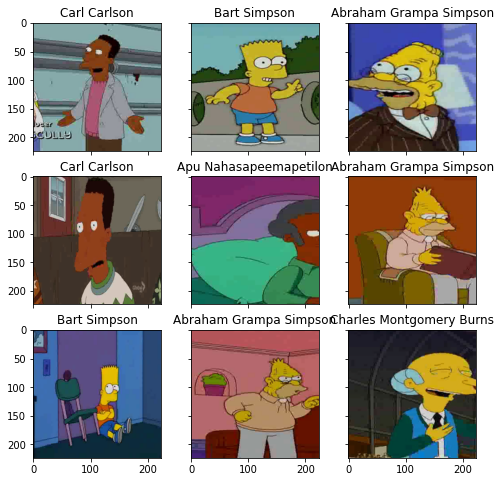

In [18]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [19]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.fc1 = nn.Linear(96 * 5 * 5, 96 * 5 * 5)
        self.fc2 = nn.Linear(96 * 5 * 5, 96 * 5 * 5)
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        logits = self.out(x)
        return logits

In [20]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [21]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [22]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [23]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [24]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [25]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [26]:
#history = train(train_dataset, val_dataset, model=simple_cnn, epochs=4, batch_size=64)

Построим кривые обучения

In [27]:
loss, acc, val_loss, val_acc = zip(*history)

NameError: ignored

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
np.random.seed(10)
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [28]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
actual_labels, y_pred

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1_score(actual_labels, y_pred, average='micro')

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=5, ncols=5,figsize=(22, 22), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),186,55,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(2, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=16, color='black',fontweight='bold')

**Что было сделано с исходной сеткой:**


1.   Ничего не делая. Accuracy=0.6
2.   Добавил эпох. Стало чуть-чуть лучше (нет).
3.   Добавил BathNorm после conv-слоев и два fc-слоя перед out-ом. Accuracy=0.7
4.   Дальнейшие танцы с бубнами особо ничего не дали. Так что го fun-тюнить




Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [87]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_resnet50, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

In [92]:
import pandas as pd
# my_submit = pd.read_csv("journey-springfield/journey-springfield/sample_submission.csv")#sample_submission
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head(10)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [93]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [94]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [95]:
my_submit.to_csv('journey-springfield/journey-springfield/model_resnet50.csv', index=False)

In [91]:
print("Accuracy: {0:.4f}".format(evaluate(model_resnet50)))

Accuracy: 0.9511


## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [29]:
import os
import torchvision
import time

from torchvision import models, datasets
from tqdm.autonotebook import trange

Обучать будем так же, как и в семинаре. Поправим немного и погнали обучать))

In [55]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {'train': train_dataset, 'val': val_dataset} # Тут поправил
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = label_encoder.classes_[list(range(0, 42))] # Тут поправил

use_gpu = torch.cuda.is_available()

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(150, 120))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [31]:
print(dataset_sizes)

{'train': 15699, 'val': 5234}


Пока что ништяк, вроде нигде не наксячил.

In [32]:
# Трейн-луп взят с семинара

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    #Ваш код здесь
    losses = {'train': [], "val": []}

    pbar = trange(num_epochs, desc="Epoch:")

    for epoch in pbar:

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in tqdm(dataloaders[phase], leave=False, desc=f"{phase} iter:"):
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                if phase=="train":
                    optimizer.zero_grad()

                # forward pass
                if phase == "eval":
                    with torch.no_grad():
                        outputs = model(inputs)
                else:
                    outputs = model(inputs)
                preds = torch.argmax(outputs, -1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            # Ваш код здесь
            losses[phase].append(epoch_loss)
            
            pbar.set_description('{} Loss: {:.4f} Acc: {:.4f}'.format(
                                    phase, epoch_loss, epoch_acc
                                ))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

In [33]:
def evaluate(model):
    model.eval()
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на gpu, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forard pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

# AlexNet

In [ ]:
model = models.alexnet(pretrained=True)

In [ ]:
num_features = 9216
model.classifier = nn.Linear(num_features, 42)

if use_gpu:
    model = model.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer_ft = torch.optim.Adam(model.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
#model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

In [ ]:
import seaborn as sns

sns.set(style="whitegrid", font_scale=1.4)

# Построим график лосса при обучении и валидации

#Ваш код здесь
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

In [ ]:
print("Accuracy: {0:.4f}".format(evaluate(model))) # Accuracy: 0.9121

In [34]:
model_extractor = models.alexnet(pretrained=True)

Заморозим features extractor

In [35]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

num_features = 9216
model_extractor.classifier = nn.Linear(num_features, 42)

if use_gpu:
    model_extractor = model_extractor.cuda()

loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(model_extractor.classifier.parameters(), lr=1e-4)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [36]:
model_extractor, losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=5)

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
                                                          


Training complete in 8m 43s
Best val Acc: 0.820978


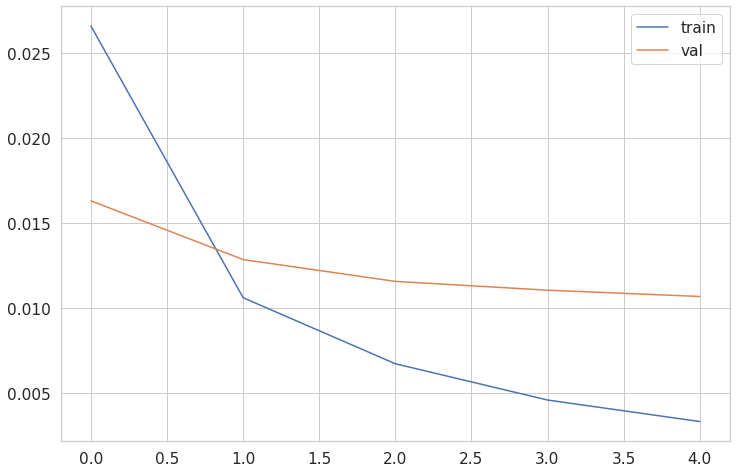

In [37]:
plt.figure(figsize=(12, 8))
plt.plot(losses['train'], label="train")
plt.plot(losses['val'], label="val")
plt.legend()
plt.show()

In [ ]:
torch.save(model_extractor.state_dict(), 'AlexNet_fine_tune.pth')

In [ ]:
model_extractor.load_state_dict(torch.load('AlexNet_fine_tune.pth'))

# ResNet

Разморозим последний слой

In [39]:
model_resnet50 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_resnet50.parameters():
    param.requires_grad = False

model_resnet50.fc = nn.Linear(2048, 42)

if use_gpu:
    model_resnet50 = model_resnet50.cuda()

In [46]:
history = train(train_dataset, val_dataset, model=model_resnet50, epochs=8, batch_size=64)


epoch:   0%|          | 0/8 [00:00<?, ?it/s]

loss 0.8667824027496384




epoch:  12%|█▎        | 1/8 [03:16<22:53, 196.22s/it]


Epoch 001 train_loss: 0.8668     val_loss 0.2908 train_acc 0.8100 val_acc 0.9347
loss 0.2317227780903416




epoch:  25%|██▌       | 2/8 [06:29<19:31, 195.26s/it]


Epoch 002 train_loss: 0.2317     val_loss 0.2779 train_acc 0.9404 val_acc 0.9356
loss 0.09470124827609243




epoch:  38%|███▊      | 3/8 [09:42<16:12, 194.57s/it]


Epoch 003 train_loss: 0.0947     val_loss 0.2695 train_acc 0.9752 val_acc 0.9354
loss 0.06654871862408511




epoch:  50%|█████     | 4/8 [12:55<12:56, 194.16s/it]


Epoch 004 train_loss: 0.0665     val_loss 0.2190 train_acc 0.9810 val_acc 0.9496
loss 0.03515476666101871




epoch:  62%|██████▎   | 5/8 [16:08<09:41, 193.90s/it]


Epoch 005 train_loss: 0.0352     val_loss 0.1943 train_acc 0.9894 val_acc 0.9612
loss 0.03001065022574968




epoch:  75%|███████▌  | 6/8 [19:21<06:27, 193.52s/it]


Epoch 006 train_loss: 0.0300     val_loss 0.2301 train_acc 0.9910 val_acc 0.9505
loss 0.021787263679487263




epoch:  88%|████████▊ | 7/8 [22:33<03:12, 192.97s/it]


Epoch 007 train_loss: 0.0218     val_loss 0.2478 train_acc 0.9940 val_acc 0.9593


epoch:  88%|████████▊ | 7/8 [23:02<03:17, 197.52s/it]


KeyboardInterrupt: ignored

In [47]:
print("Accuracy: {0:.4f}".format(evaluate(model_resnet50))) 

Accuracy: 0.8880


In [49]:
torch.save(model_resnet50.state_dict(), 'ResNet_tune.pth')
model_resnet50.load_state_dict(torch.load('ResNet_tune.pth'))

<All keys matched successfully>

Разморозим 2 последних слоя

In [ ]:
model_resnet50 = models.resnet50(pretrained=True)

# замораживаем параметры (веса)
for param in model_resnet50.parameters():
    param.requires_grad = False

for param in model_resnet50.layer4.parameters():
  param.requires_grad = True

for param in model_resnet50.layer3.parameters():
  param.requires_grad = True
  
model_resnet50.fc = nn.Linear(2048, 42)

if use_gpu:
    model_resnet50 = model_resnet50.cuda()

In [60]:
history = train(train_dataset, val_dataset, model=model_resnet50, epochs=6, batch_size=64)



epoch:   0%|          | 0/6 [00:00<?, ?it/s]

loss 0.5700590279375936







train iter::  10%|▉         | 24/246 [22:23<01:32,  2.40it/s]

epoch:  17%|█▋        | 1/6 [03:41<18:28, 221.73s/it]


Epoch 001 train_loss: 0.5701     val_loss 0.2989 train_acc 0.8564 val_acc 0.9144
loss 0.20085343086375532







train iter::  10%|▉         | 24/246 [26:04<01:32,  2.40it/s]

epoch:  33%|███▎      | 2/6 [07:23<14:46, 221.66s/it]


Epoch 002 train_loss: 0.2009     val_loss 0.2371 train_acc 0.9485 val_acc 0.9375
loss 0.11819691060730148







train iter::  10%|▉         | 24/246 [29:45<01:32,  2.40it/s]

epoch:  50%|█████     | 3/6 [11:04<11:04, 221.46s/it]


Epoch 003 train_loss: 0.1182     val_loss 0.2317 train_acc 0.9682 val_acc 0.9431
loss 0.08031573785284202







train iter::  10%|▉         | 24/246 [33:29<01:32,  2.40it/s]

epoch:  67%|██████▋   | 4/6 [14:48<07:24, 222.32s/it]


Epoch 004 train_loss: 0.0803     val_loss 0.2077 train_acc 0.9781 val_acc 0.9543
loss 0.07256495744537265







train iter::  10%|▉         | 24/246 [37:12<01:32,  2.40it/s]

epoch:  83%|████████▎ | 5/6 [18:30<03:42, 222.32s/it]


Epoch 005 train_loss: 0.0726     val_loss 0.2267 train_acc 0.9788 val_acc 0.9549
loss 0.05902917666128306







train iter::  10%|▉         | 24/246 [40:53<01:32,  2.40it/s]

epoch: 100%|██████████| 6/6 [22:12<00:00, 222.03s/it]


Epoch 006 train_loss: 0.0590     val_loss 0.2603 train_acc 0.9848 val_acc 0.9494


In [64]:
torch.save(model_resnet50.state_dict(), 'ResNet_2unfreeze_6_epoch_tune.pth')
model_resnet50.load_state_dict(torch.load('ResNet_2unfreeze_6_epoch_tune.pth'))

<All keys matched successfully>

In [84]:
history2 = train(train_dataset, val_dataset, model=model_resnet50, epochs=4, batch_size=64)



epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.06735419402348446







train iter::  10%|▉         | 24/246 [1:28:17<01:32,  2.40it/s]

epoch:  25%|██▌       | 1/4 [03:41<11:03, 221.11s/it]


Epoch 001 train_loss: 0.0674     val_loss 0.1939 train_acc 0.9821 val_acc 0.9591
loss 0.0598132847901143







train iter::  10%|▉         | 24/246 [1:31:58<01:32,  2.40it/s]

epoch:  50%|█████     | 2/4 [07:22<07:22, 221.27s/it]


Epoch 002 train_loss: 0.0598     val_loss 0.2105 train_acc 0.9831 val_acc 0.9545
loss 0.043028957328230345







train iter::  10%|▉         | 24/246 [1:35:40<01:32,  2.40it/s]

epoch:  75%|███████▌  | 3/4 [11:04<03:41, 221.30s/it]


Epoch 003 train_loss: 0.0430     val_loss 0.2173 train_acc 0.9883 val_acc 0.9528
loss 0.05044373502720868







train iter::  10%|▉         | 24/246 [1:39:21<01:32,  2.40it/s]

epoch: 100%|██████████| 4/4 [14:45<00:00, 221.43s/it]


Epoch 004 train_loss: 0.0504     val_loss 0.2566 train_acc 0.9873 val_acc 0.9511


In [86]:
torch.save(model_resnet50.state_dict(), 'ResNet_2unfreeze_8_epoch_tune.pth')
model_resnet50.load_state_dict(torch.load('ResNet_2unfreeze_8_epoch_tune.pth'))

<All keys matched successfully>

### На Kaggle получилось сразу выбить 0.97024

# Inception v3


In [76]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {'train': train_dataset, 'val': val_dataset}
                  
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                              shuffle=True, num_workers=2)
               for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}


In [66]:
model_inc_v3 = models.inception_v3(pretrained=True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


In [73]:
# print(model_inc_v3)

In [77]:
model_inc_v3.AuxLogits.fc = nn.Linear(768, 42)
model_inc_v3.fc = nn.Linear(2048, 42)

In [80]:
num_features = 25088
model_inc_v3.classifier = nn.Linear(num_features, 42)

if use_gpu:
    model_inc_v3 = model_inc_v3.cuda()

In [82]:
model_inc_v3.aux_logits = False
#model_inc_v3, losses = train_model(model_inc_v3, loss_fn, optimizer, exp_lr_scheduler, num_epochs=5) Не завелось